<a href="https://colab.research.google.com/github/sanderson0398/Anderson-Samuel-Resume/blob/master/nn_model_bike_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages and Get Data

In [1]:
import pandas as pd
import tensorflow as tf
import re
import sys
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
bikes

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
0,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13
1,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32
2,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27
3,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10
4,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16632,11/30/12,4,19,0,1,1,0.66,0,7.04,7.0010,18,359
16633,11/30/12,4,20,0,1,1,0.66,0,7.04,7.0010,12,233
16634,11/30/12,4,21,0,1,1,0.75,6,6.10,5.0012,14,169
16635,11/30/12,4,22,0,1,1,0.75,0,6.10,5.9978,18,145


In [2]:
df_h = bikes[bikes['holiday'] == 1] 



In [3]:
df_h['dteday'].unique()

array(['1/17/11', '2/21/11', '4/15/11', '5/30/11', '7/4/11', '9/5/11',
       '10/10/11', '11/11/11', '11/24/11', '12/26/11', '1/2/12',
       '1/16/12', '2/20/12', '4/16/12', '5/28/12', '7/4/12', '9/3/12',
       '10/8/12', '11/12/12', '11/22/12'], dtype=object)

Split date into month, day, and year. 

In [4]:
bikes['mnth'] = bikes['dteday'].str.split('/').str[0].astype(int)
bikes['day'] = bikes['dteday'].str.split('/').str[1].astype(int)
bikes['yr'] = bikes['dteday'].str.split('/').str[2].astype(int)
bikes['day_of_week'] = pd.to_datetime(bikes['dteday']).apply(lambda x: x.day_name())
bikes = pd.get_dummies(bikes,columns=['day_of_week'],prefix='',prefix_sep='')
bikes['total_rented'] = bikes['casual'] + bikes['registered']
#Drop Date
bikes = bikes.drop('dteday',1)
visual_data = bikes
print(bikes.info())
bikes.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        16637 non-null  int64  
 1   hr            16637 non-null  int64  
 2   holiday       16637 non-null  int64  
 3   workingday    16637 non-null  int64  
 4   weathersit    16637 non-null  int64  
 5   hum           16637 non-null  float64
 6   windspeed     16637 non-null  int64  
 7   temp_c        16637 non-null  float64
 8   feels_like_c  16637 non-null  float64
 9   casual        16637 non-null  int64  
 10  registered    16637 non-null  int64  
 11  mnth          16637 non-null  int64  
 12  day           16637 non-null  int64  
 13  yr            16637 non-null  int64  
 14  Friday        16637 non-null  uint8  
 15  Monday        16637 non-null  uint8  
 16  Saturday      16637 non-null  uint8  
 17  Sunday        16637 non-null  uint8  
 18  Thursday      16637 non-nu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,...,day,yr,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,total_rented
0,1,0,0,0,1,0.81,0,3.28,3.0014,3,...,1,11,0,0,1,0,0,0,0,16
1,1,1,0,0,1,0.80,0,2.34,1.9982,8,...,1,11,0,0,1,0,0,0,0,40
2,1,2,0,0,1,0.80,0,2.34,1.9982,5,...,1,11,0,0,1,0,0,0,0,32
3,1,3,0,0,1,0.75,0,3.28,3.0014,3,...,1,11,0,0,1,0,0,0,0,13
4,1,4,0,0,1,0.75,0,3.28,3.0014,0,...,1,11,0,0,1,0,0,0,0,1
5,1,5,0,0,2,0.75,6,3.28,1.0016,0,...,1,11,0,0,1,0,0,0,0,1
6,1,6,0,0,1,0.80,0,2.34,1.9982,2,...,1,11,0,0,1,0,0,0,0,2
7,1,7,0,0,1,0.86,0,1.40,1.0016,1,...,1,11,0,0,1,0,0,0,0,3
8,1,8,0,0,1,0.75,0,3.28,3.0014,1,...,1,11,0,0,1,0,0,0,0,8
9,1,9,0,0,1,0.76,0,7.04,7.0010,8,...,1,11,0,0,1,0,0,0,0,14


Split and  train data

In [5]:
# take out the correct results from the dataset
casual = bikes.pop('casual')
registered = bikes.pop('registered')
y_df = bikes.pop('total_rented')

In [6]:
X_train, X_val, y_train, y_val = train_test_split(bikes, y_df,test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,test_size=0.5,random_state=42)

print('training examples:',len(X_train))
print('validation examples:',len(X_val))
print('testing examples:',len(X_test))

training examples: 13309
validation examples: 1664
testing examples: 1664


Scaling

In [7]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# create scaler
scaler = MinMaxScaler()
# fit and transform in one step
normalized_bikes = scaler.fit_transform(bikes.values)
normalized_bikes_df = pd.DataFrame(normalized_bikes,columns=bikes.columns)

In [16]:
# Test Other Models for accuracy to compare to our Nerual network
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = {'KNN':KNeighborsRegressor(n_neighbors = 3,n_jobs=-1),
          'Regression':LinearRegression(n_jobs=-1),
          'SVM':SVR(),
          'Random Forest':RandomForestRegressor(n_jobs=-1,max_depth=10),
          'GB Forest':GradientBoostingRegressor()}

model_trained = {}
for name, reg in models.items():
    model = reg.fit(X_train,y_train)
    yhat = model.predict(X_test)
    MSE = mean_squared_error(y_test,yhat)
    model_trained[name] = model
    print(name," RMSE: ", round(MSE**.5,2), " r2: ",
          str(round(100*(r2_score(y_test, yhat)),2))+'%')

KNN  RMSE:  106.1  r2:  64.9%
Regression  RMSE:  138.77  r2:  39.95%
SVM  RMSE:  147.55  r2:  32.11%
Random Forest  RMSE:  49.48  r2:  92.37%
GB Forest  RMSE:  64.2  r2:  87.15%


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024,input_shape=(len(X_train.columns),),activation='relu'),
    tf.keras.layers.Dropout(0.125),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(1024,activation='relu'),
    #tf.keras.layers.Dropout(0.125),
    #tf.keras.layers.Dense(1024,activation='relu'),
    #tf.keras.layers.Dropout(0.125),
    tf.keras.layers.Dense(1,activation='selu')
])

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),loss='mae',metrics=[tf.keras.metrics.RootMeanSquaredError()])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=8,restore_best_weights=True)

history = model.fit(X_train,y_train, validation_data=(X_val,y_val),batch_size=32,epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
416/416 [==============================] - 5s 4ms/step - loss: 2044.8383 - root_mean_squared_error: 38333.5938 - val_loss: 191.5772 - val_root_mean_squared_error: 261.1271
Epoch 2/200
416/416 [==============================] - 1s 4ms/step - loss: 193.1214 - root_mean_squared_error: 266.0082 - val_loss: 191.5772 - val_root_mean_squared_error: 261.1271
Epoch 3/200
416/416 [==============================] - 2s 4ms/step - loss: 193.1214 - root_mean_squared_error: 266.0082 - val_loss: 191.5772 - val_root_mean_squared_error: 261.1271
Epoch 4/200
416/416 [==============================] - 1s 3ms/step - loss: 193.1214 - root_mean_squared_error: 266.0082 - val_loss: 191.5772 - val_root_mean_squared_error: 261.1271
Epoch 5/200
416/416 [==============================] - 1s 3ms/step - loss: 193.1214 - root_mean_squared_error: 266.0082 - val_loss: 191.5772 - val_root_mean_squared_error: 261.1271
Epoch 6/200
416/416 [==============================] - 1s 3ms/step - loss: 193.1214 - root_m

In [10]:
import numpy as np
predictions = np.round(model.predict(X_val),1)

result = mean_squared_error(y_val, predictions, squared=False)
r2 = r2_score(y_val,predictions)
print(round(result,2),str(round(100*r2,2))+'%')

261.16 -116.62%


In [11]:
import matplotlib.pyplot as plt

'''def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error ')
    plt.plot(hist['index'], hist['mse'], label='Train Error')
    plt.plot(hist['index'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    

plot_history()'''

"def plot_history():\n    plt.figure()\n    plt.xlabel('Epoch')\n    plt.ylabel('Mean Square Error ')\n    plt.plot(hist['index'], hist['mse'], label='Train Error')\n    plt.plot(hist['index'], hist['val_mse'], label = 'Val Error')\n    plt.legend()\n    \n\nplot_history()"

In [12]:
def plot_acc(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

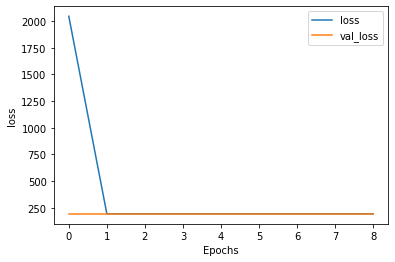

NN RMSE: 258.05372352614916


In [13]:
# Test the Model and Plot the loss


plot_acc(history, 'loss')

yhat = model.predict(X_test)
RMSE = mean_squared_error(y_test,yhat) ** 0.5
print("NN RMSE:",RMSE)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              20480     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [15]:
predictions

array([[-1.8],
       [-1.8],
       [-1.8],
       ...,
       [-1.8],
       [-1.8],
       [-1.8]], dtype=float32)